# How to use scranpy

Greetings, Pythonista! Are you eager to perform into single-cell analysis, similar to the techniques detailed in the [OSCA Book](https://bioconductor.org/books/release/OSCA/)? You've landed in the right place. `scranpy` harnesses the very same core library employed by [scran.chan](https://github.com/LTLA/scran.chan) and [Kana](https://github.com/kanaverse/kana), thanks to the work of Aaron, who has implemented a significant portion of the methods in C++.

This ever updating notebook will demonstrate the functionality provided by the library.

## Load a dataset

But before we dig deeper, lets load a dataset for analysis. Lets download the Zeisel scRNA-seq brain dataset from our [test datasets](https://github.com/kanaverse/random-test-files/releases/tag/zeisel-brain-v1.0.0). We use the `read_tenx_h5` function from the [singlecellexperiment](https://github.com/BiocPy/SingleCellExperiment) package to read this data file.

In [1]:
import singlecellexperiment as sce
data = sce.read_tenx_h5("./tenx.h5")
print(data)

Class SingleCellExperiment with 20006 features and 3005 cells 
  main_experiment_name: None 
  assays: ['counts'] 
  features: Index(['id', 'name'], dtype='object') 
  cell annotations: [] 
  reduced dimensions: None 
  alternative experiments: None


### Extract the matrix and feature vector that contains gene symbols.

In [2]:
matrix = data.assay("counts")
features = [x.decode() for x in data.row_data["name"].tolist()]

## Run the analysis

`scranpy` provides an easy [analyze function](https://biocpy.github.io/scranpy/tutorial.html#running-the-analysis) to perform all the steps in the workflow. This includes

1. Quality control ([`scranpy.quality_control`](https://biocpy.github.io/scranpy/api/scranpy.quality_control.html))
2. Normalization and log-transformation ([`scranpy.normalization`](https://biocpy.github.io/scranpy/api/scranpy.normalization.html))
3. Feature selection ([`scranpy.feature_selection`](https://biocpy.github.io/scranpy/api/scranpy.feature_selection.html))
4. Dimensionality reduction with PCA, UMAP and t-SNE ([`scranpy.dimensionality_reduction`](https://biocpy.github.io/scranpy/api/scranpy.dimensionality_reduction.html))
5. Clustering ([`scranpy.clustering`](https://biocpy.github.io/scranpy/api/scranpy.clustering.html))
6. Marker detection ([`scranpy.marker_detection`](https://biocpy.github.io/scranpy/api/scranpy.clustering.html))

In [3]:
import scranpy
results = scranpy.analyze(matrix, features)

`results` is a namedtuple that contains the outputs of various steps in the workflow. This can be marshalled into a `singlecellexperiment` object.

In [4]:
result_sce = results.to_sce(matrix)
print(result_sce)

Class SingleCellExperiment with 20006 features and 2874 cells 
  main_experiment_name: None 
  assays: ['counts', 'logcounts'] 
  features: [] 
  cell annotations: ['sums', 'detected', 'subset_proportions', 'size_factors', 'clusters'] 
  reduced dimensions: ['pca', 'tsne', 'umap'] 
  alternative experiments: None


## Plot the results

Lets explore some of the results and visualize them. 

In [5]:
import biocborn as bb
import numpy as np
import seaborn as sns


### Extract cluster labels

In [6]:
clusters = [f"cluster_{i+1}" for i in results.clusters]

### Plot Embeddings

The [biocborn]() package provides methods to easily visualize slots stored in BiocPy data structures. 

/home/jkanche/miniconda3/envs/biocpy/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


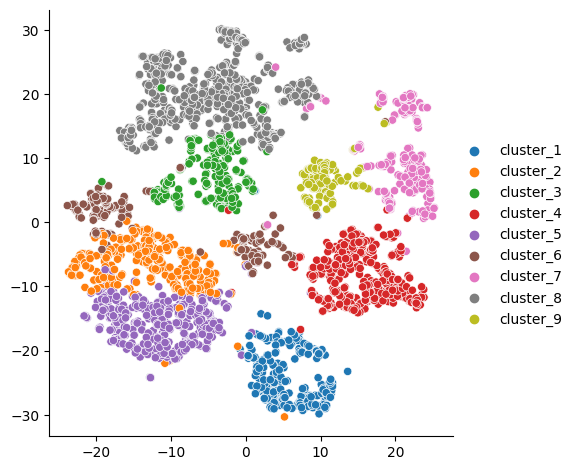

In [7]:
bb.plot_reduced_dim(result_sce.reduced_dim("tsne"), color_by=clusters)

/home/jkanche/miniconda3/envs/biocpy/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


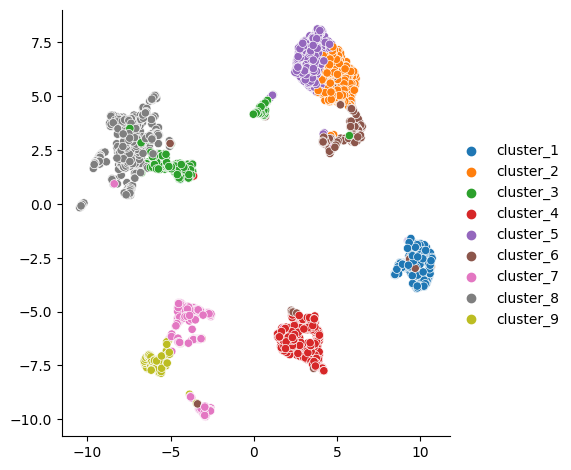

In [8]:
bb.plot_reduced_dim(result_sce.reduced_dim("umap"), color_by=clusters)

### Color by expression of a gene

In addition to visualizing the embeddings, we can also overlay the expression of a gene of interest, e.g. "Map1a".

In [9]:
map1a_idx = features.index("Map1a")
map1a_idx

2128

Access the logcounts of this gene

In [10]:
map1a_lc = result_sce.assay("logcounts")[map1a_idx, :]
map1a_lc

/home/jkanche/miniconda3/envs/biocpy/lib/python3.9/site-packages/delayedarray/DelayedArray.py:841: UserWarning: slicing for <class 'scipy.sparse._csc.csc_matrix'> does not discard dimensions with scalar indices
  warnings.warn(str(e))


array([1.90387168, 2.12118489, 1.52639997, ..., 0.        , 2.02474888,
       0.        ])

/home/jkanche/miniconda3/envs/biocpy/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


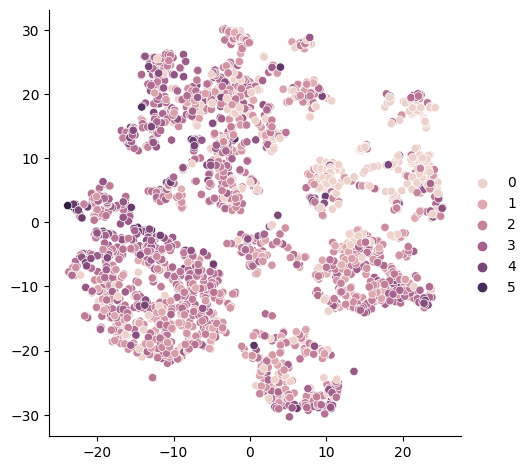

In [11]:
bb.plot_reduced_dim(result_sce.reduced_dim("tsne"), color_by = map1a_lc.tolist())

your own colors?

/home/jkanche/miniconda3/envs/biocpy/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


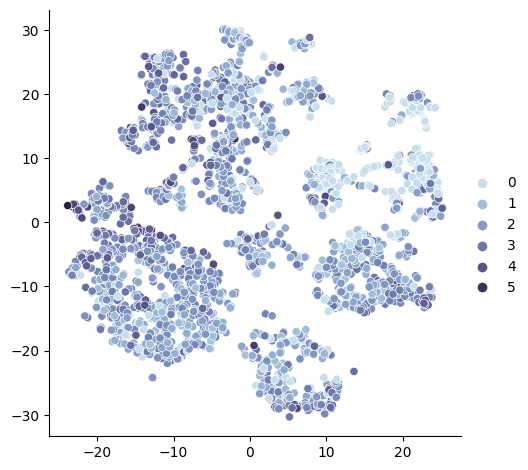

In [12]:
bb.plot_reduced_dim(result_sce.reduced_dim("tsne"), color_by = map1a_lc.tolist(), palette=sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True))

## Box Plots

Lets explore the expression of the same gene ("Map1a") across clusters as box plots.

Note: not the best effort but it works right now.

<Axes: >

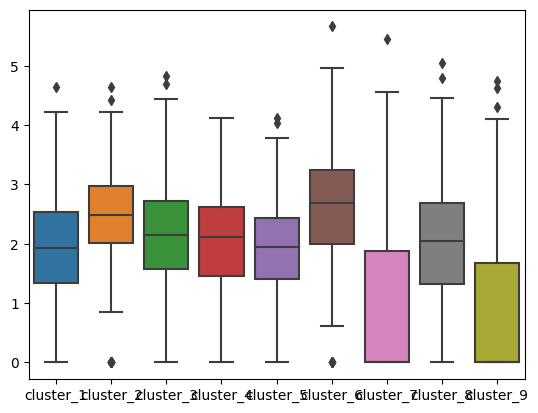

In [13]:
sns.boxplot(x=clusters, y=map1a_lc)

## But what about markers?

There's no obvious place to store markers in a singlecellexperiment object, but they are available as part of the output "results".

Lets access markers for the frst cluster (fyi, clusters start at 0).

Note: this print is ugly, but its a nested dataframe.

In [14]:
results.markers[0][map1a_idx, ]

BiocFrame with 1 rows & 6 columns 
contains row names?: False 
+----------------------+----------------------+------------------------------------------------------------------+------------------------------------------------------------------+------------------------------------------------------------------+----------------------------------------------------------------+
|        means         |       detected       |                              cohen                               |                               lfc                                |                          delta_detected                          |                              auc                               |
+----------------------+----------------------+------------------------------------------------------------------+------------------------------------------------------------------+------------------------------------------------------------------+-------------------------------------------------------------